# 3가지 모델 비교 실험

relevance, ensemble, mutiagent RAG 3가지 모델에 대해서 결과를 출력하고 Gound Truth를 가지고 평가진행.


In [1]:
import os
import argparse
from pprint import pprint
from dotenv import load_dotenv
from langchain_teddynote import logging

from crew import Crew
from graph_relevancerag import RelevanceRAG
from graph_ensemblerag import EnsembleRAG
from graph_multiagentrag import MultiAgentRAG

from utils import *

# .env 파일 로드
load_dotenv(dotenv_path=".env")

# API 키 가져오기
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")

# LangSmith 추적 기능을 활성화합니다. (선택적)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

# 프로젝트 이름을 입력합니다.
logging.langsmith("RAG 0204-Evaluation")

LangSmith 추적을 시작합니다.
[프로젝트명]
RAG 0204-Evaluation


## eval

In [2]:
def get_rag_instance(
    rag_method, 
    file_folder, 
    file_number, 
    # db_folder,
    chunk_size, 
    chunk_overlap,
    search_k,
    system_prompt, 
    model_name, 
    save_graph_png
):
    """
    RAG 클래스를 동적으로 받아서 인스턴스를 생성하는 함수
    
    Params:
        rag_method: RAG 방법 ("relevance-rag", "ensemble-rag", "multiagent-rag")
        file_folder: 논문 파일이 위치한 폴더 경로
        file_number: 처리할 논문 번호
        system_prompt: system prompt
        model_name: LLM 모델 명 ("gpt-4o", "gpt-4o-mini")
        save_graph_png: graph 저장 결정
        
    Return:
        생성된 RAG 모델 인스턴스
    """
    
    # RAG 모델 인스턴스 생성
    if rag_method == "relevance-rag":
        return RelevanceRAG(file_folder, file_number, chunk_size, chunk_overlap, search_k, system_prompt, model_name, save_graph_png)
        
    elif rag_method == "ensemble-rag":
        return EnsembleRAG(file_folder, file_number, chunk_size, chunk_overlap, search_k, system_prompt, model_name, save_graph_png)
        
    elif rag_method == "multiagent-rag":
        return MultiAgentRAG(file_folder, file_number, chunk_size, chunk_overlap, search_k, system_prompt, model_name, save_graph_png)


def main(
        config_folder:str="./config",
        data_folder:str="./data",
        file_num_list:list=[11],
        rag_method:str="multiagent-rag", 
        chunk_size:int=1000, 
        chunk_overlap:int=100, 
        search_k:int=10,    
        model_name:str="gpt-4o",
        save_graph_png:bool = False



):    
    category_names = ["CAM (Cathode Active Material)", "Electrode (half-cell)", "Morphological Properties", "Cathode Performance"]

    
    
    
    file_folder = f"{data_folder}/input_data"
    
    
    eval_df = pd.DataFrame(columns = ["paper_number","category_name","type", "result"])
    sample_name_searcher_question = """Use all of the NCM cathode sample names (e.g., 'NCM-622', 'pristine NCM', 'M-NCM') provided in the electrochemical performance section. You just output sample names. Do Not output like '- NCM622' , just output 'NCM622."""
    ## 각 논문에 대해 반복
    for file_number in file_num_list:
        print(f"#####    {file_number}번째 논문    #####")
        print(f"##       rag method     : {rag_method}")
        category_df = pd.DataFrame(columns = ["paper_number","category_name","type", "result"])
        ## Sample Name Searcher
        crew = Crew(
            file_folder=f"{data_folder}/input_data/", 
            file_number=file_number, 
            rag_method="crew-rag", 
            chunk_size=chunk_size, 
            chunk_overlap=chunk_overlap, 
            search_k=search_k, 
            model_name=model_name   
        )
        sample_name_searcher_chain = crew.sample_name_searcher()
        sample_names = sample_name_searcher_chain.invoke(sample_name_searcher_question)
        print(f"##       Sample Names    : {sample_names}")
        
        for category_number in range(1,5):
            print(f"##          Category Name   : {category_names[category_number-1]}")
            category_names = ["CAM (Cathode Active Material)", "Electrode (half-cell)", "Morphological Properties", "Cathode Performance"]
            

            ## config 파일과 system_prompt 와 invoke_input 불러오기
            system_prompt = load_system_prompt(config_folder=config_folder, category_number=category_number, rag_method=rag_method)
            invoke_input = load_invoke_input(config_folder=config_folder, category_number=category_number, rag_method=rag_method, sample_names=sample_names)
    
            ## graph 호출
            voltai_graph = get_rag_instance(
                rag_method=rag_method, 
                file_folder=f"{data_folder}/input_data/", 
                file_number=file_number, 
                chunk_size=chunk_size, 
                chunk_overlap=chunk_overlap, 
                search_k=search_k, 
                system_prompt=system_prompt,
                model_name=model_name, 
                save_graph_png=save_graph_png,
            ).graph
            
            ## 질문이 딕셔너리 형태일 경우와 아닌 경우를 처리
            if isinstance(invoke_input, dict):
                result = voltai_graph.invoke(**invoke_input)
            else:
                result = voltai_graph.invoke(*invoke_input)
            
            x = "000000"+f"{file_number}"
            x = x[-3:]
            file_name = f"paper_{x}"
            print(file_name)
            # JSON 파일 경로
            file_path = f"./data/ground_truth/{file_name}_gt.json"

            # JSON 파일 읽기
            with open(file_path, "r", encoding="utf-8") as file:
                gt = json.load(file)
            
            
            ## RAG method에 따른 결과 확인
            if result.get("answer"):
                temp_answer = result["answer"][0][category_names[category_number-1]]
            elif result.get("discussion"):
                print(result["discussion"])
                temp_answer = result["discussion"][0][category_names[category_number-1]]
            elif result.get("messages"):
                temp_answer = result["messages"][-1][category_names[category_number-1]]

            ## 결과 저장
            category_df.loc[category_number-1, "paper_number"] = file_number
            category_df.loc[category_number-1, "type"] = rag_method
            category_df.loc[category_number-1, "category_number"] = category_number
            category_df.loc[category_number-1, "category_name"] = category_names[category_number-1]
            category_df.loc[category_number-1, "result"] = [temp_answer] 
            category_df.loc[category_number-1, "ground_truth"] = [gt[category_names[category_number-1]]]

        
            print(f"##          Print {file_number} Result:")
            print("------------------------------------------------------------------")
            pprint(temp_answer, sort_dicts=False)        
        
            pprint(category_df.head())
        eval_df = pd.concat([eval_df, category_df])    

    return eval_df

In [4]:
file_ = [11,16,22,35,40,41,42,44,56,64]
for i in range(1):
    print(f"{i+1}번째 반복")
    df = main(file_num_list=file_,rag_method="multiagent-rag")
    df.to_csv(f"multiagent_3_df.csv", index = False)
    total_df = pd.concat([total_df, df])

1번째 반복
#####    11번째 논문    #####
##       rag method     : multiagent-rag
##       paper_011 retriever를 생성했습니다.
##          - chunk_size    :1000
##          - chunk_overlap :100
##          - retrieve_k    :10
##       Sample Names    : ['NR0', 'NR1', 'NR3', 'NR5']
##          Category Name   : CAM (Cathode Active Material)
##          ./config/multiagent-rag/c1-system-prompt.yaml를 불러왔습니다.
##          ./config/multiagent-rag/c1-question.yaml를 불러왔습니다.
##       paper_011 retriever를 생성했습니다.
##          - chunk_size    :1000
##          - chunk_overlap :100
##          - retrieve_k    :10
paper_011
##          Print 11 Result:
------------------------------------------------------------------
{'Stoichiometry information': {'NR0': {'Li ratio': 1.0,
                                       'Ni ratio': 0.33,
                                       'Co ratio': 0.33,
                                       'Mn ratio': 0.33,
                                       'O ratio': 2.0},
                  

In [2]:
# df.to_csv("eval_ensemble.csv", index=False)

df = pd.read_csv("eval_ensemble.csv")

## concat dataframe

In [2]:
import pandas as pd
relevacne_df = pd.read_csv("csv/relevance_eval_df.csv")
relevacne_df = relevacne_df[relevacne_df["paper_number"]!=39]
ensemble_df = pd.DataFrame(columns = ["paper_number","category_name","type", "result"])

multiagent_df = pd.DataFrame(columns = ["paper_number","category_name","type", "result"])


for i in range(0,5):
    df = pd.read_csv(f"csv/ensemble_eval_df{i}.csv")
    ensemble_df = pd.concat([ensemble_df, df])

for i in range(0,10):
    df = pd.read_csv(f"csv/multiagent_eval_df{i}.csv")
    multiagent_df = pd.concat([multiagent_df, df])



In [3]:
relevacne_df

,paper_number,category_name,type,result,category_number,ground_truth
0,11,CAM (Cathode Active Material),relevance-rag,[{'Stoichiometry information': {'NR0': {'Li ra...,1.0,[{'Stoichiometry information': {'NR0': {'Li ra...
1,11,Electrode (half-cell),relevance-rag,[{'Active material to Conductive additive to B...,2.0,[{'Active material to Conductive additive to B...
2,11,Morphological Properties,relevance-rag,[{'Particle size': {'NR0': 'NCM particles with...,3.0,"[{'Particle size': {'NR0': '200-300 nm', 'NR1'..."
3,11,Cathode Performance,relevance-rag,"[{'NR0': [{'Voltage range': '2.5-4.3', 'Temper...",4.0,"[{'NR0': [{'Voltage range': '2.5-4.3', 'Temper..."
4,16,CAM (Cathode Active Material),relevance-rag,[{'Stoichiometry information': {'NCM': {'Li ra...,1.0,[{'Stoichiometry information': {'NCM': {'Li ra...
...,...,...,...,...,...,...
435,56,Cathode Performance,relevance-rag,[{'pristine NCM': [{'Voltage range': '3.0-4.3'...,4.0,[{'pristine NCM': [{'Voltage range': '3.0-4.3'...
436,64,CAM (Cathode Active Material),relevance-rag,[{'Stoichiometry information': {'LNCM': {'Li r...,1.0,[{'Stoichiometry information': {'LNCM': {'Li r...
437,64,Electrode (half-cell),relevance-rag,[{'Active material to Conductive additive to B...,2.0,[{'Active material to Conductive additive to B...
438,64,Morphological Properties,relevance-rag,[{'Particle size': {'LNCM': 'uniform spherical...,3.0,"[{'Particle size': {'LNCM': None, 'CLNCM': Non..."


In [4]:
ensemble_df

,paper_number,category_name,type,result,category_number,ground_truth
0,11,CAM (Cathode Active Material),ensemble-rag,[{'Stoichiometry information': {'NR0': {'Li ra...,1.0,[{'Stoichiometry information': {'NR0': {'Li ra...
1,11,Electrode (half-cell),ensemble-rag,[{'Active material to Conductive additive to B...,2.0,[{'Active material to Conductive additive to B...
2,11,Morphological Properties,ensemble-rag,"[{'Particle size': {'NR0': '200-300 nm', 'NR1'...",3.0,"[{'Particle size': {'NR0': '200-300 nm', 'NR1'..."
3,11,Cathode Performance,ensemble-rag,"[{'NR0': [{'Voltage range': '2.5-4.3', 'Temper...",4.0,"[{'NR0': [{'Voltage range': '2.5-4.3', 'Temper..."
4,16,CAM (Cathode Active Material),ensemble-rag,[{'Stoichiometry information': {'NCM': {'Li ra...,1.0,[{'Stoichiometry information': {'NCM': {'Li ra...
...,...,...,...,...,...,...
35,56,Cathode Performance,ensemble-rag,[{'pristine NCM': [{'Voltage range': '3.0-4.3'...,4.0,[{'pristine NCM': [{'Voltage range': '3.0-4.3'...
36,64,CAM (Cathode Active Material),ensemble-rag,[{'Stoichiometry information': {'LNCM': {'Li r...,1.0,[{'Stoichiometry information': {'LNCM': {'Li r...
37,64,Electrode (half-cell),ensemble-rag,[{'Active material to Conductive additive to B...,2.0,[{'Active material to Conductive additive to B...
38,64,Morphological Properties,ensemble-rag,[{'Particle size': {'LNCM': 'uniform spherical...,3.0,"[{'Particle size': {'LNCM': None, 'CLNCM': Non..."


In [5]:
multiagent_df

,paper_number,category_name,type,result,category_number,ground_truth
0,11,CAM (Cathode Active Material),multiagent-rag,[{'Stoichiometry information': {'NR0': {'Li ra...,1.0,[{'Stoichiometry information': {'NR0': {'Li ra...
1,11,Electrode (half-cell),multiagent-rag,[{'Active material to Conductive additive to B...,2.0,[{'Active material to Conductive additive to B...
2,11,Morphological Properties,multiagent-rag,"[{'Particle size': {'NR0': '200-300 nm', 'NR1'...",3.0,"[{'Particle size': {'NR0': '200-300 nm', 'NR1'..."
3,11,Cathode Performance,multiagent-rag,"[{'NR0': [{'Voltage range': '2.5-4.3', 'Temper...",4.0,"[{'NR0': [{'Voltage range': '2.5-4.3', 'Temper..."
4,16,CAM (Cathode Active Material),multiagent-rag,[{'Stoichiometry information': {'NCM': {'Li ra...,1.0,[{'Stoichiometry information': {'NCM': {'Li ra...
...,...,...,...,...,...,...
35,56,Cathode Performance,multiagent-rag,[{'pristine NCM': [{'Voltage range': '3.0-4.3'...,4.0,[{'pristine NCM': [{'Voltage range': '3.0-4.3'...
36,64,CAM (Cathode Active Material),multiagent-rag,[{'Stoichiometry information': {'LNCM': {'Li r...,1.0,[{'Stoichiometry information': {'LNCM': {'Li r...
37,64,Electrode (half-cell),multiagent-rag,[{'Active material to Conductive additive to B...,2.0,[{'Active material to Conductive additive to B...
38,64,Morphological Properties,multiagent-rag,[{'ParticleSize': {'LNCM': 'uniform spherical ...,3.0,"[{'Particle size': {'LNCM': None, 'CLNCM': Non..."


In [6]:
def eval_sentence_generator(category_number, result_dict):
    if category_number == 1:
        values = list(result_dict.values())
        return f"The {values} is {values[1]} commercially obtained, and synthesized with {values[2]}, and {values[3]}, and, {values[4]} for {values[5]} at {values[6]}, with {values[7]} doping and {values[8]} coating "
    
    elif category_number == 2:
        values = list(result_dict.values())
        return f"The electrode is manufactured by {values[0]} with {values[1]} and {values[2]} is {values[3]}"
    
    elif category_number == 3:
        values = list(result_dict.values())
        return f"Particle size is {values[0]}, Particle shape is {values[1]} and Particle distribution is {values[2]}. Also Coating layer characteristics are {values[3]}. Crystal structure and lattice characteristics are {values[4]}."
    
    elif category_number == 4:
        s = ""
        for k, v in result_dict.items():
            for i in range(len(v)):
                s += f"C-rate and Specific capacity of {k} in {v[i]['Voltage range']} voltage range and {v[i]['Temperature']} temperature is {v[i]['C-rate and Specific capacity']}."
        return s

In [7]:
import ast
# result_sentence와 ground_truth_sentence 리스트 생성
result_sentences = []
ground_truth_sentences = []

for _, row in relevacne_df.iterrows():
    category_number = int(row['category_number'])
    result_dict = ast.literal_eval(row['result'])[0]
    ground_truth_dict = ast.literal_eval(row['ground_truth'])[0]
    
    result_sentences.append(eval_sentence_generator(category_number, result_dict))
    ground_truth_sentences.append(eval_sentence_generator(category_number, ground_truth_dict))

# 새로운 열 추가
relevacne_df['result_sentence'] = result_sentences
relevacne_df['ground_truth_sentence'] = ground_truth_sentences

In [8]:
import ast
# result_sentence와 ground_truth_sentence 리스트 생성
result_sentences = []
ground_truth_sentences = []

for _, row in ensemble_df.iterrows():
    category_number = int(row['category_number'])
    result_dict = ast.literal_eval(row['result'])[0]
    ground_truth_dict = ast.literal_eval(row['ground_truth'])[0]
    
    result_sentences.append(eval_sentence_generator(category_number, result_dict))
    ground_truth_sentences.append(eval_sentence_generator(category_number, ground_truth_dict))

# 새로운 열 추가
ensemble_df['result_sentence'] = result_sentences
ensemble_df['ground_truth_sentence'] = ground_truth_sentences

In [9]:
import ast
# result_sentence와 ground_truth_sentence 리스트 생성
result_sentences = []
ground_truth_sentences = []

for _, row in multiagent_df.iterrows():
    category_number = int(row['category_number'])
    result_dict = ast.literal_eval(row['result'])[0]
    ground_truth_dict = ast.literal_eval(row['ground_truth'])[0]
    
    result_sentences.append(eval_sentence_generator(category_number, result_dict))
    ground_truth_sentences.append(eval_sentence_generator(category_number, ground_truth_dict))

# 새로운 열 추가
multiagent_df['result_sentence'] = result_sentences
multiagent_df['ground_truth_sentence'] = ground_truth_sentences

In [10]:
relevacne_df.to_csv("csv/relevance_sentence_iter_10.csv",index=False)
ensemble_df.to_csv("csv/ensemble_sentence_iter_10.csv",index=False)
multiagent_df.to_csv("csv/multiagent_sentence_iter_10.csv",index=False)

## Scoring

In [1]:
from metrics.metric_eval import evaluate_all_metrics
import pandas as pd
relevacne_df=pd.read_csv("csv/relevance_sentence_iter_10.csv")
ensemble_df=pd.read_csv("csv/ensemble_sentence_iter_10.csv")
multiagent_df=pd.read_csv("csv/multiagent_sentence_iter_10.csv")


/Users/limseongbeom/anaconda3/envs/voltai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/limseongbeom/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
## 모든 metric data frame
metric_df = relevacne_df[["ground_truth_sentence", "result_sentence"]].apply(
    lambda row: evaluate_all_metrics(row["ground_truth_sentence"], row["result_sentence"]), 
    axis=1
).apply(pd.Series)

## rouge 수정
rouge_df = metric_df["ROUGE"].apply(pd.Series)

## 최종 evaluation data frame
relevance_score_df = pd.concat([relevacne_df, metric_df.drop(columns=["ROUGE"]), rouge_df], axis=1)

In [2]:
## 모든 metric data frame
metric_df = ensemble_df[["ground_truth_sentence", "result_sentence"]].apply(
    lambda row: evaluate_all_metrics(row["ground_truth_sentence"], row["result_sentence"]), 
    axis=1
).apply(pd.Series)

## rouge 수정
rouge_df = metric_df["ROUGE"].apply(pd.Series)

## 최종 evaluation data frame
ensemble_score_df = pd.concat([ensemble_df, metric_df.drop(columns=["ROUGE"]), rouge_df], axis=1)

In [4]:
## 모든 metric data frame
metric_df = multiagent_df[["ground_truth_sentence", "result_sentence"]].apply(
    lambda row: evaluate_all_metrics(row["ground_truth_sentence"], row["result_sentence"]), 
    axis=1
).apply(pd.Series)

## rouge 수정
rouge_df = metric_df["ROUGE"].apply(pd.Series)

## 최종 evaluation data frame
multiagent_score_df = pd.concat([multiagent_df, metric_df.drop(columns=["ROUGE"]), rouge_df], axis=1)

In [5]:
relevance_score_df.to_csv("csv/score_relevance_iter_10.csv")
ensemble_score_df.to_csv("csv/score_ensemble_iter_10.csv")
multiagent_score_df.to_csv("csv/score_multiagent_iter_10.csv")

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_score_comparisons(df):
    metrics = ['BLEU', 'METEOR', 'Semantic Similarity (STS)', 'rouge1', 'rouge2', 'rougeL']
    custom_colors = ["#004823", "#007200", "#38B000", "#70E000", "#9EF01A", "#CCFF33"]
    
    # Type별 점수 비교
    plt.figure(figsize=(12, 6))
    df_melted = df.melt(id_vars=['type'], value_vars=metrics, var_name='Metric', value_name='Score')
    
    # 평균 계산
    df_melted = df_melted.groupby(['type', 'Metric'], as_index=False).mean()
    
    ax = sns.barplot(data=df_melted, x='type', y='Score', hue='Metric', palette=custom_colors)

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels([])
    plt.legend(framealpha=0)
    # plt.legend().remove()  # 범례 제거
    plt.show()

    # category_number별 + type별 점수 평균 비교
    plt.figure(figsize=(12, 6))
    df_melted = df.melt(id_vars=['category_number', 'type'], value_vars=metrics, var_name='Metric', value_name='Score')
    
    # 평균 계산
    df_melted = df_melted.groupby(['category_number', 'type', 'Metric'], as_index=False).mean()
    
    ax = sns.barplot(data=df_melted, x='category_number', y='Score', hue='Metric', palette=custom_colors)


    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels([])
    plt.legend(framealpha=0)
    # plt.legend().remove()  # 범례 제거
    plt.show()

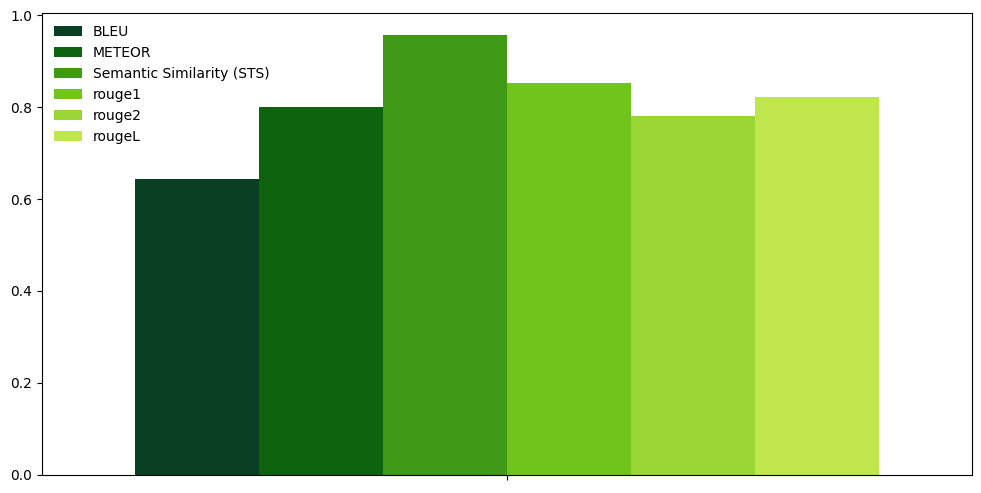

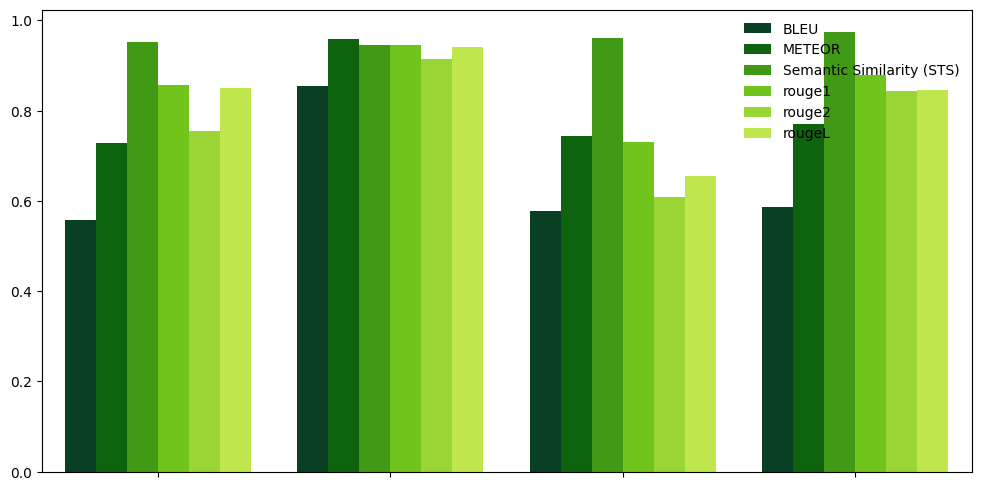

In [8]:
plot_score_comparisons(relevance_score_df)

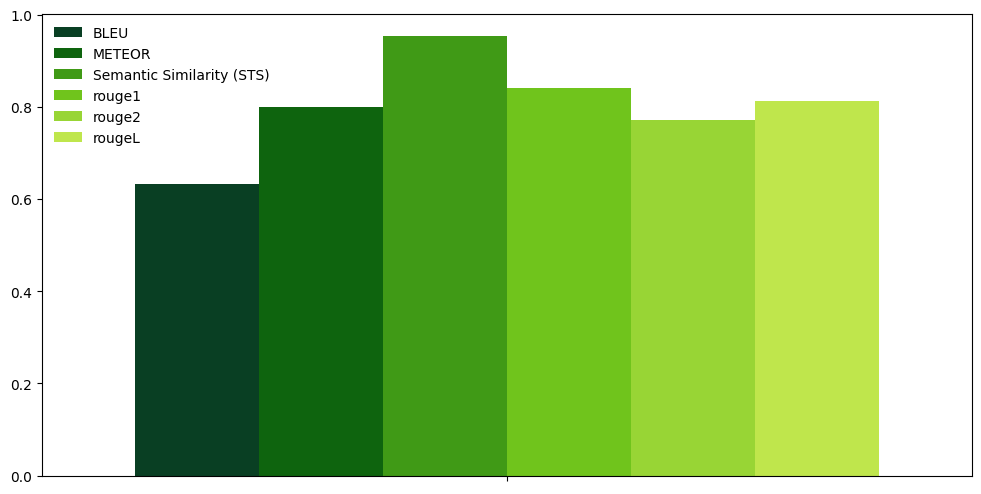

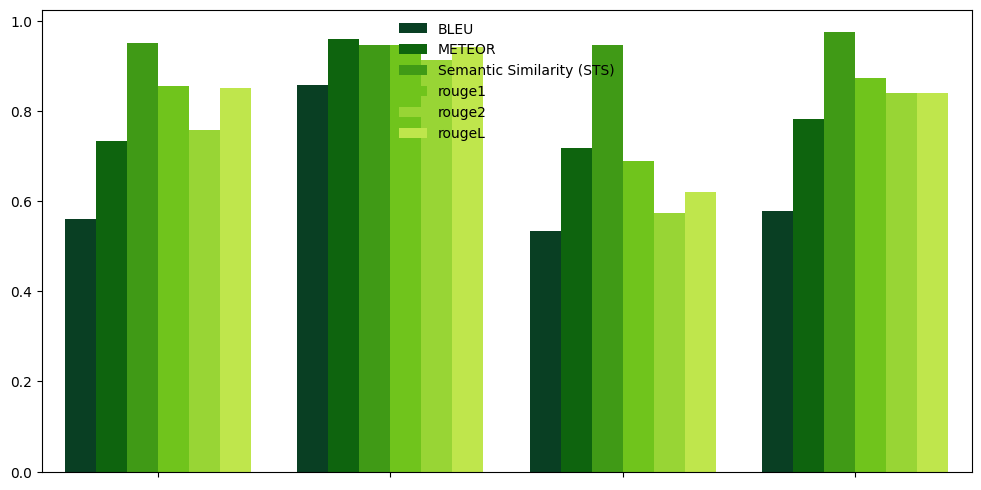

In [9]:
plot_score_comparisons(ensemble_score_df)

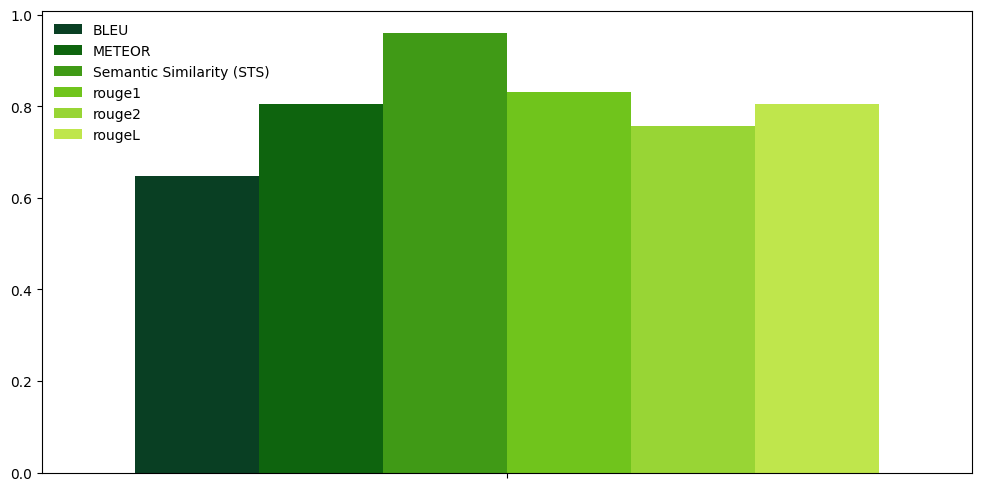

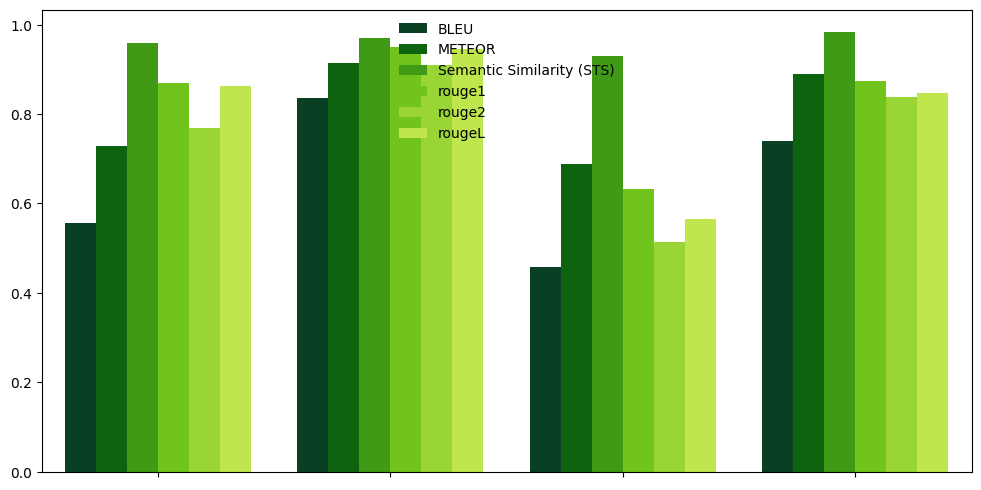

In [9]:
plot_score_comparisons(df)

In [10]:
df.to_csv("multiagent_score.csv", index=False)